<a href="https://colab.research.google.com/github/LeoTU911/SCC413/blob/main/VAE_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Mar  1 00:28:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/LeoTU911/SCC413

Cloning into 'SCC413'...
remote: Enumerating objects: 701, done.
remote: Total 701 (delta 0), reused 0 (delta 0), pack-reused 701
Receiving objects: 100% (701/701), 30.38 MiB | 11.23 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [ ]:
#!rm -rf /content/SCC413
#!ls -R
#!rm -rf /content/SCC413/generate/generated/*

In [ ]:
import os
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import keras
import joblib
from keras import backend as K
from keras import losses
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Concatenate, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image

In [ ]:
import joblib
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array

In [86]:
#image pre-processing
filePath1 = '/content/SCC413/Keras_convVAE_dataset/CUHK_training_cropped_photos'
filePath2 = '/content/SCC413/Keras_convVAE_dataset/CUHK_training_cropped_sketches'
filePath3 = '/content/SCC413/Keras_convVAE_dataset/CUHK_testing_cropped_photos'


def imageGeneration(image, image_list):
  image_horizontal = img_to_array(cv2.flip(image, 1))
  image_list.append(image_horizontal)

  image_vertical   = img_to_array(cv2.flip(image, -1))
  image_list.append(image_vertical)

  image_HorVer_tmp = cv2.flip(image, 1)
  image_HorVer     = img_to_array(cv2.flip(image_HorVer_tmp, -1))
  image_list.append(image_HorVer)

  image_VerHor_tmp = cv2.flip(image, -1)
  image_VerHor     = img_to_array(cv2.flip(image_VerHor_tmp, 1))
  image_list.append(image_VerHor)

  image_rotate1    = img_to_array(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
  image_list.append(image_rotate1)

  image_rotate2    = img_to_array(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
  image_list.append(image_rotate2)
  
  return image_list

def img2Dataset(filePath, n_imgGenerate):
  images = []
  for fileName in os.listdir(filePath):
    if fileName.endswith('.jpg'):
      img_tmp = cv2.imread(os.path.join(filePath, fileName))
      img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
      img_tmp = cv2.resize(img_tmp, (128, 128))
      img_array = np.array(img_tmp)
      images.append(img_array)

      for i in range(n_imgGenerate):
        images = imageGeneration(img_tmp, images)
  
  dataset = np.array(images).reshape((-1, 128, 128, 3)).astype('float32') / 255.0
  return dataset

n_imgGenerate = 7

images_train   = img2Dataset(filePath1, n_imgGenerate)
sketches_train = img2Dataset(filePath2, n_imgGenerate)
#images_test    = img2Dataset(filePath3)

In [87]:
#image pre-processing
filePath1 = '/content/SCC413/Keras_convVAE_dataset/CUHK_training_cropped_photos'
filePath2 = '/content/SCC413/Keras_convVAE_dataset/CUHK_training_cropped_sketches'
filePath3 = '/content/SCC413/Keras_convVAE_dataset/CUHK_testing_cropped_photos'


def imageGeneration(image, image_list):
  image_horizontal = img_to_array(cv2.flip(image, 1))
  image_list.append(image_horizontal)

  image_vertical   = img_to_array(cv2.flip(image, -1))
  image_list.append(image_vertical)

  image_HorVer_tmp = cv2.flip(image, 1)
  image_HorVer     = img_to_array(cv2.flip(image_HorVer_tmp, -1))
  image_list.append(image_HorVer)

  image_VerHor_tmp = cv2.flip(image, -1)
  image_VerHor     = img_to_array(cv2.flip(image_VerHor_tmp, 1))
  image_list.append(image_VerHor)

  image_rotate1    = img_to_array(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
  image_list.append(image_rotate1)

  image_rotate2    = img_to_array(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
  image_list.append(image_rotate2)
  
  return image_list

def img2Dataset(filePath, n_imgGenerate):
  images = []
  images_gray = []
  for fileName in os.listdir(filePath):
    if fileName.endswith('.jpg'):
      img_tmp = cv2.imread(os.path.join(filePath, fileName))
      img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
      img_tmp = cv2.resize(img_tmp, (128, 128))
      img_array = np.array(img_tmp)
      img_rgb = img_array[:,:,:3]
      img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140])
      images.append(img_array)
      images_gray.append(img_gray)

      for i in range(n_imgGenerate):
        images = imageGeneration(img_tmp, images)
  
  dataset = np.array(images_gray).reshape((-1, 128, 128, 1)).astype('float32') / 255.0
  return dataset

n_imgGenerate = 7

images_train   = img2Dataset(filePath1, n_imgGenerate)
sketches_train = img2Dataset(filePath2, n_imgGenerate)
#images_test    = img2Dataset(filePath3)

In [96]:
#image pre-processing
filePath1 = '/content/SCC413/Keras_convVAE_dataset/CUHK_training_cropped_photos'
filePath2 = '/content/SCC413/Keras_convVAE_dataset/CUHK_training_cropped_sketches'
filePath3 = '/content/SCC413/Keras_convVAE_dataset/CUHK_testing_cropped_photos'


def imageGeneration(image, image_list):
  image_horizontal = img_to_array(cv2.flip(image, 1))
  image_list.append(image_horizontal)

  image_vertical   = img_to_array(cv2.flip(image, -1))
  image_list.append(image_vertical)

  image_HorVer_tmp = cv2.flip(image, 1)
  image_HorVer     = img_to_array(cv2.flip(image_HorVer_tmp, -1))
  image_list.append(image_HorVer)

  image_VerHor_tmp = cv2.flip(image, -1)
  image_VerHor     = img_to_array(cv2.flip(image_VerHor_tmp, 1))
  image_list.append(image_VerHor)

  image_rotate1    = img_to_array(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
  image_list.append(image_rotate1)

  image_rotate2    = img_to_array(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
  image_list.append(image_rotate2)
  
  return image_list

def img2Dataset(filePath, n_imgGenerate):
  images = []
  images_gray = []
  for fileName in os.listdir(filePath):
    if fileName.endswith('.jpg'):
      img_tmp = cv2.imread(os.path.join(filePath, fileName))
      img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)
      img_tmp = cv2.resize(img_tmp, (128, 128))
      img_array = np.array(img_tmp)
      images.append(img_array)

      for i in range(n_imgGenerate):
        images = imageGeneration(img_tmp, images)
  
  dataset = np.array(images).reshape((-1, 128, 128, 1)).astype('float32') / 255.0
  return dataset

n_imgGenerate = 7

images_train   = img2Dataset(filePath1, n_imgGenerate)
sketches_train = img2Dataset(filePath2, n_imgGenerate)
#images_test    = img2Dataset(filePath3)

<ipython-input-96-9de2df97b10b>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(images).reshape((-1, 128, 128, 1)).astype('float32') / 255.0


ValueError: ignored

In [95]:
print(images_train.shape)
print(sketches_train.shape)
print(images_test.shape)

(0, 128, 128, 1)
(0, 128, 128, 1)
(100, 128, 128, 3)


In [90]:
input_shape = (128, 128, 1)
batch_size = 32
latent_dim = 2
encoder_layers = [16, 32, 64, 128, 256]
decoder_layers = [256, 128, 128, 64, 32, 16, 8]

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# 编码器
inputs = Input(shape=input_shape)
x = inputs
for filters in encoder_layers:
    x = Conv2D(filters, kernel_size=3, strides=2, activation='LeakyReLU', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D(padding='same')(x)
shape_before_flattening = x.shape[1:]
x = Flatten()(x)
x = Dense(latent_dim, activation='LeakyReLU')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, z_mean, name='encoder')

# 解码器
#latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
decoder_inputs = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening))(decoder_inputs)
x = Reshape(shape_before_flattening)(x)
for filters in decoder_layers:
    x = Conv2DTranspose(filters, kernel_size=3, strides=(2,2), activation='LeakyReLU', padding='same')(x)
decoded = Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)
decoder = Model(decoder_inputs, decoded, name='decoder')

encoder.summary()
decoder.summary()

# VAE模型
reconstruction = decoder(z)
vae = Model(inputs, reconstruction, name='vae')

# 计算损失函数
reconstruction_loss = K.mean(K.binary_crossentropy(K.flatten(inputs), K.flatten(reconstruction)))
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# 编译模型
#vae.compile(optimizer='adam', loss=losses.mean_squared_error, metrics=['accuracy'])
vae.compile(optimizer='adam')

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 batch_normalization_37 (Bat  (None, 64, 64, 16)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_38 (Bat  (None, 16, 16, 32)       64  

Epoch 1/200
3/3 [==============================] - 9s 204ms/step - loss: 11357.3779
Epoch 2/200
3/3 [==============================] - 0s 17ms/step - loss: 11335.7549
Epoch 3/200
3/3 [==============================] - 0s 16ms/step - loss: 11287.9023
Epoch 4/200
3/3 [==============================] - 0s 16ms/step - loss: 11028.2344
Epoch 5/200
3/3 [==============================] - 0s 16ms/step - loss: 10823.3691
Epoch 6/200
3/3 [==============================] - 0s 16ms/step - loss: 10631.0186
Epoch 7/200
3/3 [==============================] - 0s 17ms/step - loss: 10407.6602
Epoch 8/200
3/3 [==============================] - 0s 16ms/step - loss: 10264.3047
Epoch 9/200
3/3 [==============================] - 0s 17ms/step - loss: 10147.7178
Epoch 10/200
3/3 [==============================] - 1s 306ms/step - loss: 9995.8154 - val_loss: 10828.6807
Epoch 11/200
3/3 [==============================] - 0s 16ms/step - loss: 9975.1641
Epoch 12/200
3/3 [==============================] - 0s 16ms/st

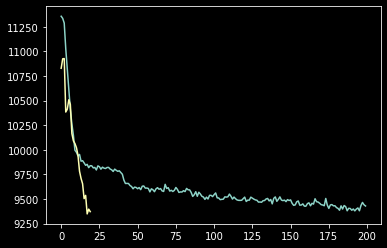

In [91]:
# 训练模型

callbacks_list = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
                  EarlyStopping(monitor='val_loss', patience=5)]

vae.fit(images_train, 
    sketches_train,
    epochs=200,
    batch_size=batch_size,
    validation_split=0.1,
    validation_freq=10
    #callbacks=callbacks_list
    )

# plot
plt.plot(vae.history.history["loss"])
plt.plot(vae.history.history["val_loss"])

# save model
#vae.save('vae_model_1.0')

In [ ]:
from google.colab import files
files.download('/content/vae_model_1.0/') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cp -r /content/vae_model_1.0/ /content/drive/MyDrive/

1/1 [==============================] - 0s 25ms/step


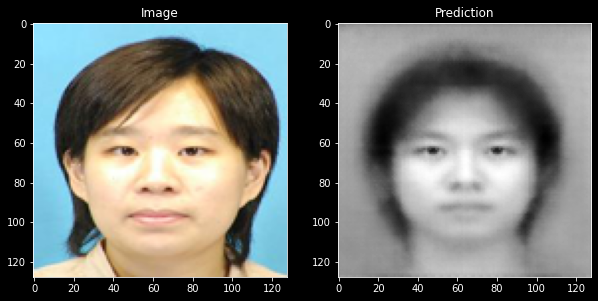

1/1 [==============================] - 0s 20ms/step


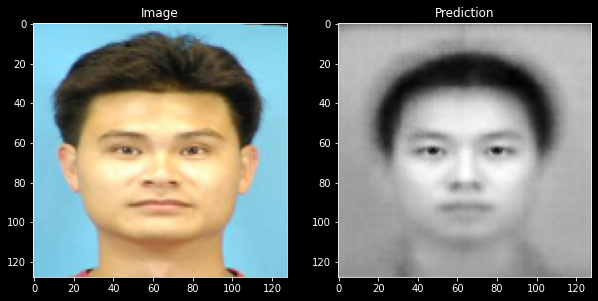

1/1 [==============================] - 0s 23ms/step


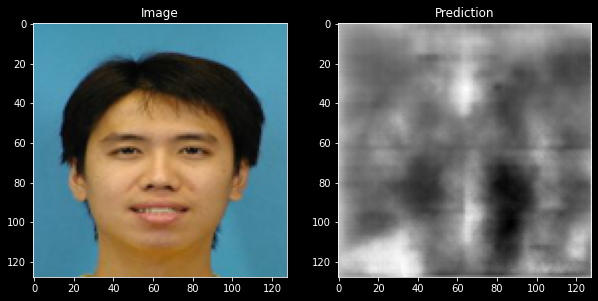

1/1 [==============================] - 0s 23ms/step


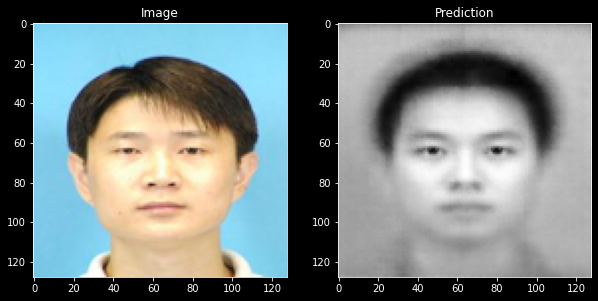

1/1 [==============================] - 0s 24ms/step


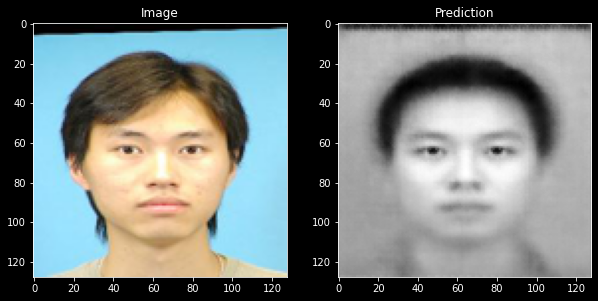

1/1 [==============================] - 0s 21ms/step


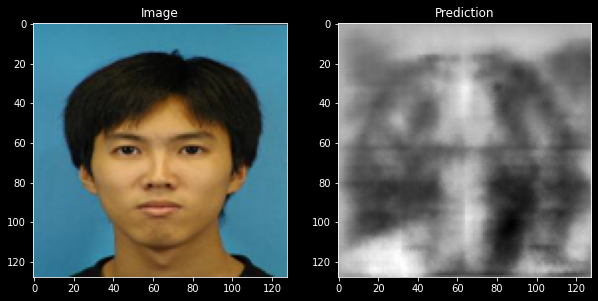

1/1 [==============================] - 0s 35ms/step


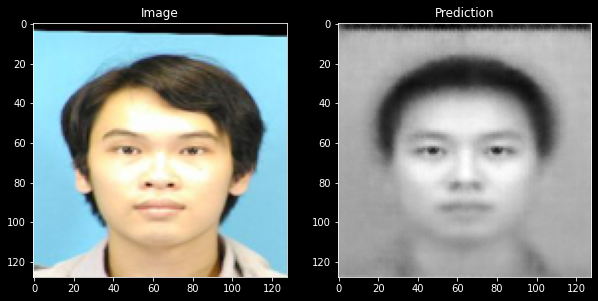

1/1 [==============================] - 0s 21ms/step


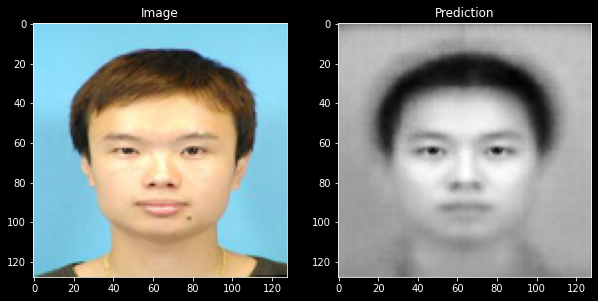

1/1 [==============================] - 0s 25ms/step


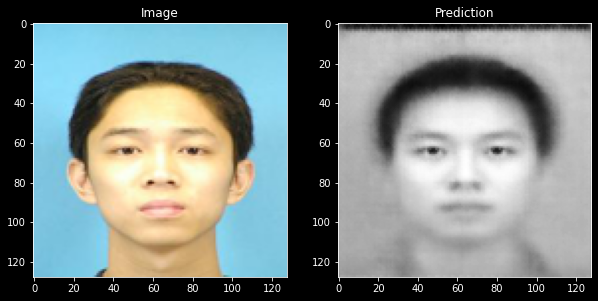

1/1 [==============================] - 0s 31ms/step


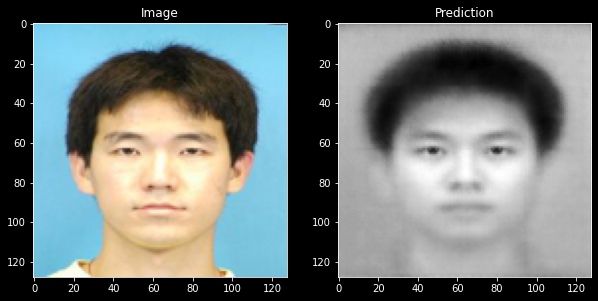

1/1 [==============================] - 0s 23ms/step


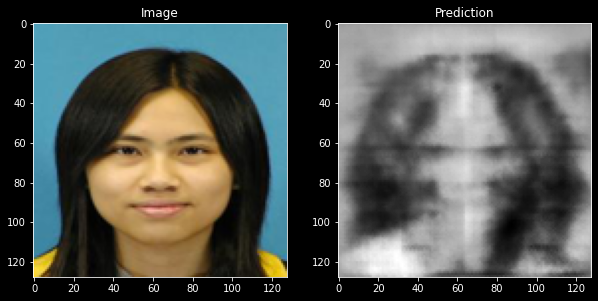

1/1 [==============================] - 0s 25ms/step


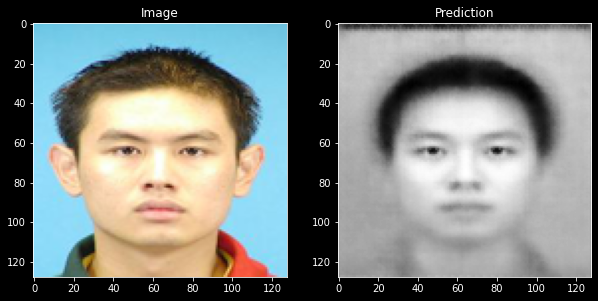

1/1 [==============================] - 0s 25ms/step


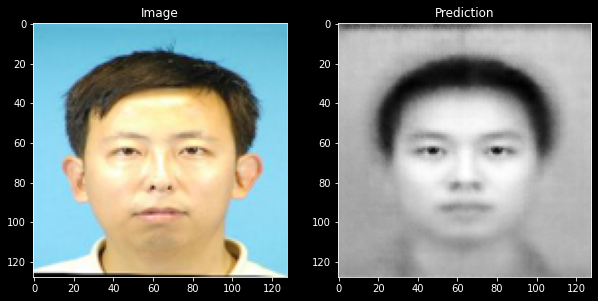

1/1 [==============================] - 0s 21ms/step


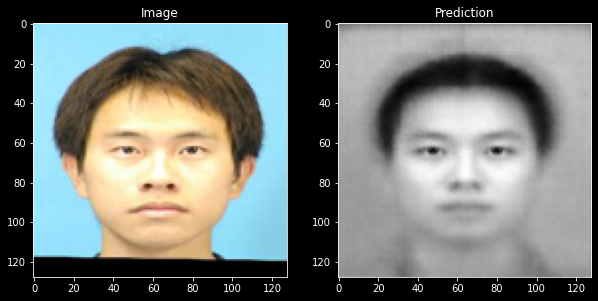

1/1 [==============================] - 0s 23ms/step


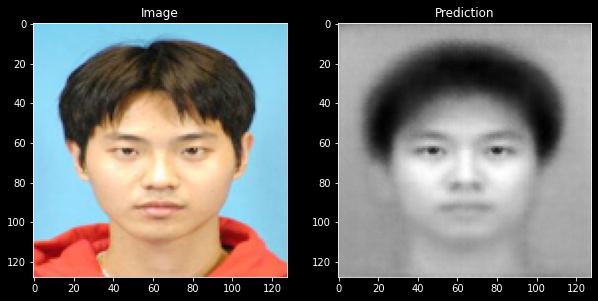

1/1 [==============================] - 0s 21ms/step


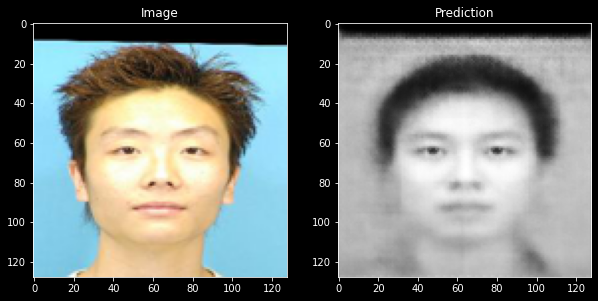

1/1 [==============================] - 0s 21ms/step


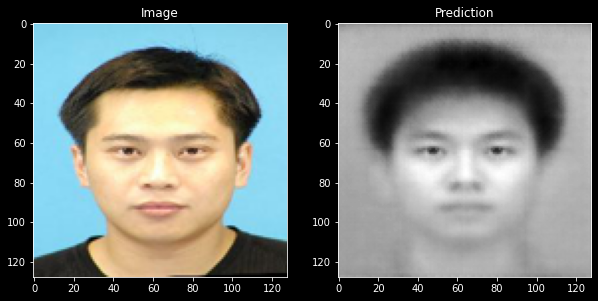

1/1 [==============================] - 0s 21ms/step


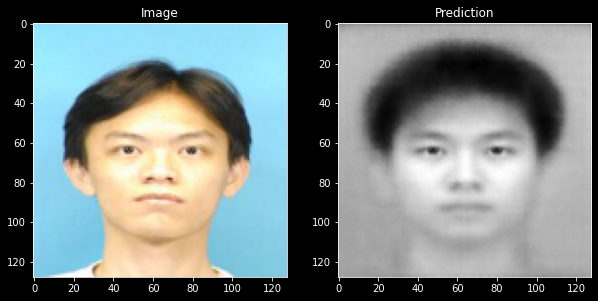

1/1 [==============================] - 0s 24ms/step


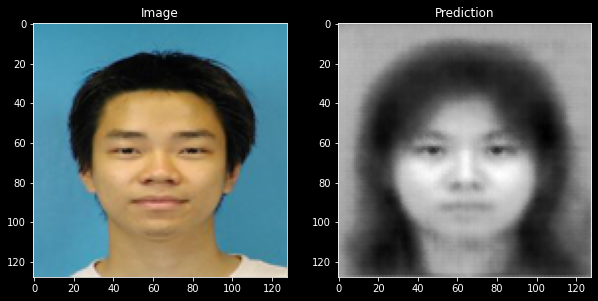

1/1 [==============================] - 0s 23ms/step


KeyboardInterrupt: ignored

In [93]:
# 使用VAE模型生成素描图片
for fileName in os.listdir(filePath3):
    # 读取输入图片
    image_tmp = Image.open(os.path.join(filePath3, fileName))
    
    # 转换为模型的输入格式
    image_tmp = image_tmp.resize((128, 128))
    image_gray = image_tmp.convert('L')
    img_tmp = np.array(image_gray).reshape((1,128,128,1)).astype('float32') / 255.
#    img_tmp = np.array(img_tmp).reshape((1,128,128,3))

    # 使用VAE模型生成素描图片
#    z_mean,_ = encoder.predict(img_tmp)
    # test = encoder.predict(x_train)
    # print(test)
    sketch_img = vae.predict(img_tmp)

    sketch_img = np.clip(sketch_img, 0.0, 1.0).reshape(128, 128, 1)
#    predict_img = sketch_img.reshape(256,256)


    # 转换为PIL Image格式并保存为文件
#    sketch_img = sketch_img[0] * 255.
    #sketch_img = np.clip(sketch_img, 0, 255).astype('uint8')
#    sketch_img = sketch_img.astype('uint8').reshape((*sketch_img.shape[:-1],))
#    sketch_img = Image.fromarray(sketch_img)
    #sketch_filename = os.path.splitext(fileName)[0] + "_predSketch.jpg"
    #sketch_img.save(os.path.join(filePath, sketch_filename))


    # 显示生成的素描图片
    plt.style.use('dark_background')
    plt.figure(figsize = (10,10))
    plt.subplot(1,2,1)
    plt.title('Image')
    plt.imshow(image_tmp)
    plt.subplot(1,2,2)
    plt.title('Prediction')
    plt.imshow(sketch_img, cmap = 'gray')
    plt.show()
